## COVID19 CT Pneumonia Detection - Multiclass Case
By Adrian Yijie Xu
(https://medium.com/@adrianitsaxu)

As discussed in "Detecting COVID-19 induced Pneumonia from Chest X-rays with Transfer Learning: An implementation in Tensorflow and Keras."
(https://github.com/EXJUSTICE/GradientCrescent)

50% test accuracy with 4 classes
100% test accuracy with 3 classes

Conclusion: Viral Pneumonia indistinguishable from COVID19: acceptable, given that COVID19 is itself caused by viral means.



In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#set randomness for reproducibility
from numpy.random import seed
seed(8) #1
from tensorflow import set_random_seed
set_random_seed(7) #2

#

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os



!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip



Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:00, 169MB/s]
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all/

In [0]:
print(os.listdir("/content/"))

#Print and remove zips once done

!rm Covid_Data_GradientCrescent.zip



['.config', 'Covid_Data_GradientCrescent.zip', 'all', 'two', 'sample_data']


In [0]:
#Enable this cell to remove viral pneumonia class. Remember to Change model's final layer to 3 neurons.
!rm -rf /content/all/test/pneumonia_vir

!rm -rf /content/all/train/pneumonia_vir

In [0]:
from os import listdir
data_list = listdir('/content/all/train')

#Delete some classes that may interfere


data_list

['pneumonia_bac', 'covid', 'normal']

Case 2: COVID vs Normal vs Tertiary Pneumonia (Bacterial and Viral)
VGG Initialization

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf


DATASET_PATH  = '/content/all/train'
test_dir =  '/content/all/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE =0.0001



#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="categorical"
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="categorical"
                                                 
                                                  )



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 160 images belonging to 3 classes.
Found 40 images belonging to 3 classes.


Layer Modification at upper layer of VGG16

In [0]:
#Simple CNN model based on VGG16. Set dense layer neuron count to 3 if viral pneumonia class is removed


from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


conv_base.trainable = False


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

In [0]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 2,098,179
Non-trainable params: 14,714,688
_________________________________________________________________
None


Training

In [0]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,                        
                       )



16
4
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 10s 637ms/step - loss: 1.0498 - acc: 0.4313 - val_loss: 0.9339 - val_acc: 0.5500
Epoch 2/100
16/16 [==============================] - 4s 270ms/step - loss: 0.8062 - acc: 0.6250 - val_loss: 0.8428 - val_acc: 0.5500
Epoch 3/100
16/16 [==============================] - 4s 264ms/step - loss: 0.7823 - acc: 0.6500 - val_loss: 0.6858 - val_acc: 0.6750
Epoch 4/100
16/16 [==============================] - 4s 263ms/step - loss: 0.7373 - acc: 0.6750 - val_loss: 0.6383 - val_acc: 0.6750
Epoch 5/100
16/16 [==============================] - 4s 266ms/step - loss: 0.6715 - acc: 0.7063 - val_loss: 0.6969 - val_acc: 0.6500
Epoch 6/100
16/16 [==============================] - 4s 269ms/step - loss: 0.6397 - acc: 0.7188 - val_loss: 0.7267 - val_acc: 0.6000
Epoch 7/100
16/16 [==============================] - 4s 271ms/step - loss: 0.6145 - acc: 0.7687 - val_loss: 0.5519 - val_acc: 0.8000
Epoch 8/100
16/16 [==============================] - 4s 268ms/step - loss: 0.529

Evaluation

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


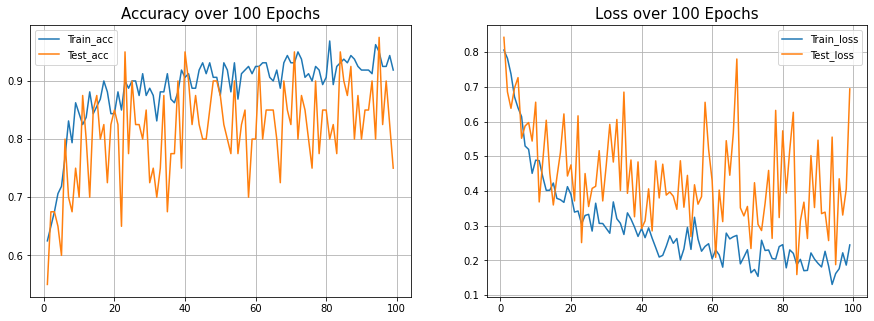

In [0]:
import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 100)

In [0]:
model.save('Covid_Multi.h5')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Predict

In [0]:

#Dont forget shuffle false
#See https://github.com/keras-team/keras/issues/6499
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=True,
        seed=42,
        
        class_mode="categorical")
eval_generator.reset()    


Found 27 images belonging to 3 classes.


In [0]:

eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

#Poor test accuracy due to the small dataset size

3/3 [==============================] - 1s 199ms/step
Test loss: 0.006713376846164465
Test accuracy: 1.0


Optional: Finetuning with a learning rate of 5E-5

In [0]:

model.compile(loss='categorical_crossentropy',
              
              optimizer=optimizers.Adam(lr=5e-5),
              metrics=['acc'])

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= 20,                        
                       )


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 5s 300ms/step - loss: 0.1551 - acc: 0.9562 - val_loss: 0.4131 - val_acc: 0.7750
Epoch 2/50
16/16 [==============================] - 4s 255ms/step - loss: 0.1716 - acc: 0.9312 - val_loss: 0.5726 - val_acc: 0.8500
Epoch 3/50
16/16 [==============================] - 4s 261ms/step - loss: 0.2124 - acc: 0.9125 - val_loss: 0.4882 - val_acc: 0.8000
Epoch 4/50
16/16 [==============================] - 4s 261ms/step - loss: 0.1440 - acc: 0.9437 - val_loss: 0.3906 - val_acc: 0.8000
Epoch 5/50
16/16 [==============================] - 4s 267ms/step - loss: 0.1794 - acc: 0.9125 - val_loss: 0.4222 - val_acc: 0.9000
Epoch 6/50
16/16 [==============================] - 4s 273ms/step - loss: 0.2027 - acc: 0.9187 - val_loss: 0.4976 - val_acc: 0.8250
Epoch 7/50
16/16 [==============================] - 4s 269ms/step - loss: 0.2004 - acc: 0.9500 - val_loss: 0.2417 - val_acc: 0.9000
Epoch 8/50
16/16 [==============================] - 4s 269ms/step - loss: 0.2233 - acc:

In [0]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])


3/3 [==============================] - 0s 36ms/step
Test loss: 0.021353596743817132
Test accuracy: 1.0


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
